*************************************
INITIALIZE
- import Python modules
*************************************

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import xgboost
from xgboost import XGBRegressor

****************************************************
IMPORT DATA
- import data from csv files
- combine into 2 dataframes:
    - Regular season
    - Postseason
- check summary statistics for resulting dataframes
****************************************************

In [4]:
#Import data

df_RS_sum = pd.read_csv('Summary_RS.csv', encoding='latin-1')
df_RS_pen = pd.read_csv('Penalties_RS.csv', encoding='latin-1')
df_RS_tgg = pd.read_csv('Team Goal-Games_RS.csv', encoding='latin-1')
df_RS_satc = pd.read_csv('SAT Counts_RS.csv', encoding='latin-1')
df_RS_satp = pd.read_csv('SAT Percentages_RS.csv', encoding='latin-1')

df_PS_sum = pd.read_csv('Summary_PS.csv', encoding='latin-1')
df_PS_pen = pd.read_csv('Penalties_PS.csv', encoding='latin-1')
df_PS_tgg = pd.read_csv('Team Goal-Games_PS.csv', encoding='latin-1')
df_PS_satc = pd.read_csv('SAT Counts_PS.csv', encoding='latin-1')
df_PS_satp = pd.read_csv('SAT Percentages_PS.csv', encoding='latin-1')

In [5]:
#Check import sample
df_PS_sum.head()

,Team,Season,GP,W,L,T,OT,P,P%,RW,...,GA,GF/GP,GA/GP,PP%,PK%,Net PP%,Net PK%,Shots/GP,SA/GP,FOW%
0,Tampa Bay Lightning,20202021,23,16,7,--,--,32.0,0.696,16,...,45.0,3.26,1.96,32.4,84.1,32.4,87.3,29.6,30.4,48.1
1,Montréal Canadiens,20202021,22,13,9,--,--,26.0,0.591,7,...,54.0,2.32,2.45,18.9,91.8,17.0,98.4,28.9,30.7,49.4
2,New York Islanders,20202021,19,11,8,--,--,22.0,0.579,7,...,53.0,2.84,2.79,20.4,65.1,16.3,65.1,28.5,35.2,51.8
3,Vegas Golden Knights,20202021,19,10,9,--,--,20.0,0.526,8,...,46.0,2.79,2.42,9.3,71.8,9.3,74.4,32.1,26.4,53.5
4,Boston Bruins,20202021,11,6,5,--,--,12.0,0.545,3,...,32.0,3.00,2.91,36.4,75.7,36.4,75.7,35.8,31.0,52.3


In [6]:
#Create regular season dataframe

#Rename column with shared name but different data
df_RS_satp = df_RS_satp.rename({'GF':'5v5 GF', 'GA':'5v5 GA'}, axis=1)

#Drop duplicate columns
df_RS_pen = df_RS_pen.drop(['GP','W','L','T','OT','P'], axis=1)
df_RS_satc = df_RS_satc.drop(['GP'], axis=1)
df_RS_satp = df_RS_satp.drop(['GP','P','P%'], axis=1)
df_RS_tgg = df_RS_tgg.drop(['GP','W','L','T','OT','P','P%'], axis=1)

#Merge dataframes to create one regular season dataframe
df = pd.merge(df_RS_sum, df_RS_pen, how='inner', on=['Team','Season'])
df = pd.merge(df, df_RS_satc, how='inner', on=['Team','Season'])
df = pd.merge(df, df_RS_satp, how='inner', on=['Team','Season'])
df = pd.merge(df, df_RS_tgg, how='inner', on=['Team','Season'])

#Drop irrelevant columns (Ties not applicable in seasons being studied)
df = df.drop(['T'], axis=1)

#Convert season column to string
df['Season'] = df['Season'].apply(str)

#Convert SAT for/against to rate per game
df['SAT For/GP'] = df['SAT For'] / df['GP']
df['SAT Agst/GP'] = df['SAT Agst'] / df['GP']

In [7]:
#Check summary statistics for regular season dataframe
df.describe()

,GP,W,L,OT,P,P%,RW,ROW,S/O Win,GF,...,Win% 3 Goal Game,Wins 1 Goal Game,Wins 2 Goal Game,Wins 3 Goal Game,Loss 1 Goal Game,Loss 2 Goal Game,Loss 3 Goal Game,OT Loss 1 Goal Game,SAT For/GP,SAT Agst/GP
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,...,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,74.311688,37.155844,28.707792,8.448052,82.759740,0.556929,28.707792,34.298701,2.857143,215.642857,...,0.499370,16.012987,7.733766,13.409091,7.564935,7.733766,13.409091,8.448052,44.869488,44.867717
std,10.380676,8.935594,7.828994,2.906028,17.944379,0.094176,8.100613,8.792547,1.693620,38.727923,...,0.163777,4.216350,2.985898,5.188743,2.976872,3.031517,5.099806,2.906028,3.125934,3.010061
min,56.000000,15.000000,12.000000,2.000000,37.000000,0.275000,11.000000,11.000000,0.000000,124.000000,...,0.032000,5.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,37.321429,35.053571
25%,69.000000,31.000000,24.000000,7.000000,72.000000,0.488000,23.000000,28.000000,2.000000,189.250000,...,0.385500,13.000000,6.000000,10.000000,5.000000,5.250000,10.000000,7.000000,42.664634,42.871951
50%,82.000000,37.000000,28.000000,8.000000,81.500000,0.569000,29.000000,34.000000,3.000000,221.000000,...,0.515500,16.000000,7.000000,14.000000,8.000000,8.000000,13.000000,8.000000,44.622570,45.009364
75%,82.000000,44.000000,34.000000,10.000000,97.750000,0.622750,35.000000,41.000000,4.000000,243.000000,...,0.618000,19.000000,10.000000,17.000000,9.000000,10.000000,16.000000,10.000000,46.908537,47.088415
max,82.000000,62.000000,56.000000,15.000000,128.000000,0.780000,49.000000,56.000000,9.000000,319.000000,...,0.875000,25.000000,16.000000,30.000000,15.000000,16.000000,30.000000,15.000000,53.609756,53.914634


In [8]:
#Create postseason dataframe following same process as regular season

df_PS_satp = df_PS_satp.rename({'GF':'5v5 GF', 'GA':'5v5 GA'}, axis=1)

df_PS_pen = df_PS_pen.drop(['GP','W','L','T','OT','P'], axis=1)
df_PS_satc = df_PS_satc.drop(['GP'], axis=1)
df_PS_satp = df_PS_satp.drop(['GP','P','P%'], axis=1)
df_PS_tgg = df_PS_tgg.drop(['GP','W','L','T','P','P%'], axis=1)

df2 = pd.merge(df_PS_sum, df_PS_pen, how='inner', on=['Team','Season'])
df2 = pd.merge(df2, df_PS_satc, how='inner', on=['Team','Season'])
df2 = pd.merge(df2, df_PS_satp, how='inner', on=['Team','Season'])
df2 = pd.merge(df2, df_PS_tgg, how='inner', on=['Team','Season'])

df2 = df2.drop(['T'], axis=1)

df2['Season'] = df2['Season'].apply(str)

df2['SAT For/GP'] = df2['SAT For'] / df2['GP']
df2['SAT Agst/GP'] = df2['SAT Agst'] / df2['GP']

In [9]:
df2.describe()

,GP,W,L,P,P%,RW,ROW,S/O Win,GF,GA,...,5v5 S%+Sv%,Wins 2 Goal Game,Wins 3 Goal Game,Loss 1 Goal Game,Loss 2 Goal Game,Loss 3 Goal Game,OT Loss 1 Goal Game,Unnamed: 18,SAT For/GP,SAT Agst/GP
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,...,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,40.000000,88.000000,88.000000
mean,10.727273,5.363636,5.329545,5.117261,2.505977,4.738636,2.409091,16.272727,29.534091,14.671023,...,98.932955,1.829545,1.397727,2.136364,1.795455,1.397727,0.806818,0.075000,47.657206,47.749411
std,6.629310,4.849889,1.981069,8.387413,3.631763,4.450221,4.173359,21.981041,18.536047,17.144004,...,3.018781,2.354851,1.847893,1.709889,1.576837,1.255240,1.239744,0.266747,6.483257,6.219736
min,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.750000,...,90.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.571429,36.400000
25%,5.750000,2.000000,4.000000,0.333000,0.333000,1.000000,0.000000,0.000000,16.000000,2.652500,...,97.150000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,43.221429,44.250000
50%,8.500000,4.000000,4.000000,0.607500,0.612500,3.000000,0.000000,7.000000,23.000000,3.355000,...,99.850000,1.000000,1.000000,2.000000,1.500000,1.000000,0.000000,0.000000,46.900219,47.431373
75%,15.000000,8.250000,6.250000,6.500000,3.250000,7.000000,3.250000,26.250000,42.000000,22.250000,...,101.000000,2.000000,2.000000,3.000000,3.000000,2.000000,1.250000,0.000000,51.723214,50.987500
max,27.000000,18.000000,12.000000,36.000000,14.000000,16.000000,17.000000,86.000000,77.000000,82.000000,...,103.800000,12.000000,9.000000,6.000000,7.000000,5.000000,5.000000,1.000000,69.500000,66.900000


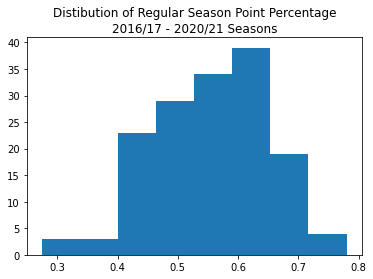

In [10]:
fig, ax = plt.subplots()

plt.hist(df['P%'], bins=8)

plt.title('Distibution of Regular Season Point Percentage\n2016/17 - 2020/21 Seasons')
plt.savefig('hist_RS_Ppct.png', dpi=144)

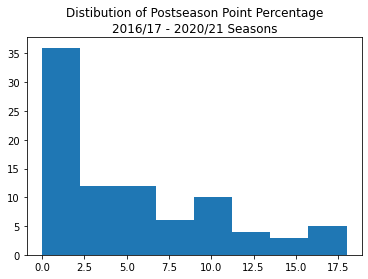

In [11]:
fig, ax = plt.subplots()

plt.hist(df2['W'], bins=8)

plt.title('Distibution of Postseason Point Percentage\n2016/17 - 2020/21 Seasons')
plt.savefig('hist_PS_W.png', dpi=144)

*************************************
INITIAL DATA ASSESSMENT
- reduce dataframes to set of variables expected to be of primary interest.  Preferentially select variables as rates or ratios from each category of statistics.
- create heat map to check correlation between selected variables
*************************************

In [12]:
#Reduce regular season dataframe for initial heatmap
df_reg = df[['W','L','OT','P%', 'RW','ROW','S/O Win','GF/GP','GA/GP','PP%','PK%','Pen Drawn/60','Pen Taken/60','SAT For','SAT Agst','SAT%','USAT %','Win% 1 Goal Game','Win% 2 Goal Game', 'Win% 3 Goal Game']]

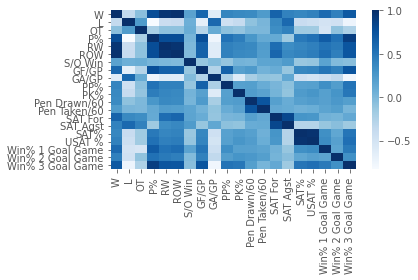

In [13]:
#Create correlation heat map for regular season
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
corr = df_reg.corr()
sns_plot = sns.heatmap(corr, cmap="Blues", annot=False)

fig = sns_plot.get_figure()
fig.tight_layout()
fig.savefig("reg_heat.png")

In [14]:
#Reduce postseason dataframe for initial heatmap
df_post = df2[['W','L','OT','P%', 'RW','ROW','GF/GP','GA/GP','PP%','PK%','Pen Drawn/60','Pen Taken/60','SAT For','SAT Agst','SAT%','USAT %','Win% 1 Goal Game','Win% 2 Goal Game', 'Win% 3 Goal Game']]

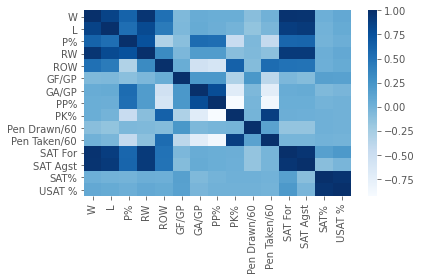

In [15]:
#Create correlation heat map for postseason
corr = df_post.corr()
sns_plot = sns.heatmap(corr, cmap="Blues", annot=False)

fig = sns_plot.get_figure()
fig.tight_layout()
fig.savefig("post_heat.png")

************************************************************
MODELLING: REGULAR SEASON
Initial model:
    - Train initial model for regular season using goal-based input variables
    - Test multiple types of regression models to find best fit.  Considering linear regression, XGBoost regression, ridge regression
Additional models:
    - Add additional variables to inital model in categorical groups to test for improved models.  
    - Additional categorical groups include shot metrics, penalties, special teams, records in close games
    - Additional models without using goal metrics
************************************************************

In [16]:
#TRAIN INITIAL MODEL M0
#Linear Regression
#Inputs: goal based variables
#Target: Regular season P%
#70/30 Train/test split

#Target Variable = Roint Percentage
reg_col_name = 'P%'

#Select feature variables
feature_names = ['GF/GP','GA/GP']

#Use 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, feature_names], df[reg_col_name], test_size=0.3,random_state=2)

#Train model & predict test set
M0 = linear_model.LinearRegression()
M0.fit(X_train,y_train)

y_pred = M0.predict(X_test)

In [17]:
#Check model metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 0.019301933879415853
Mean Squared Error: 0.0005326454997485497
Root Mean Squared Error: 0.02307911392901707
R-Squared: 0.9331582772976956
Adjusted R-Squared: 0.9318728595534206


In [18]:
#TRAIN INITIAL MODEL M0 with kfold cross validation
#Linear Regression
#Inputs: goal based variables
#Target: Regular season P%
#kfold cross validation

X, y = df[['GF/GP', 'GA/GP']], df['P%']

#Train model & predict test set
M0k = linear_model.LinearRegression()
#M0k.fit(X,y)

#y_pred = M0k.predict(X)

from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(M0k, X, y, scoring='neg_mean_absolute_error', cv=cv)
scores.mean()

-0.019066608315764132

In [19]:
#MODEL M0_XGB
#XGBoost Regression
#Inputs: goal based variables
#Target: Regular season P%

reg_col_name = 'P%'

feature_names = ['GF/GP','GA/GP']

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, feature_names], df[reg_col_name], test_size=0.3,random_state=2)

M0_XGB = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1.0, learning_rate = 0.1,
                max_depth = 4, n_estimators = 100)

M0_XGB.fit(X_train,y_train)

y_pred = M0_XGB.predict(X_test)

In [20]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 0.024832683020449716
Mean Squared Error: 0.0010186796962558568
Root Mean Squared Error: 0.031916761995162614
R-Squared: 0.8721658104466374
Adjusted R-Squared: 0.8697074606475343


In [21]:
#MODEL M0RR
#Ridge Regression
#Inputs: goal based variables
#Target: Regular season P%

reg_col_name = 'P%'

feature_names = ['GF/GP','GA/GP']

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, feature_names], df[reg_col_name], test_size=0.3,random_state=2)

M0RR = Ridge(alpha=0.1)
M0RR.fit(X_train,y_train)

y_pred = M0RR.predict(X_test)

In [22]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 0.019349022473394435
Mean Squared Error: 0.0005375438606248156
Root Mean Squared Error: 0.02318499214200461
R-Squared: 0.93254358163324
Adjusted R-Squared: 0.9312463428184946


In [23]:
#Continue regular season prediction adding additional variables to goal-based model.  Linear Regression dropped due to suspected overfitting in M0.

In [24]:
#Does adding shot metric variables improve goal based model?
#MODEL M1
#XGBoost Regression
#Inputs: goal based variables + shot-based metrics
#Target: Regular season P%

reg_col_name = 'P%'

feature_names = ['GF/GP','GA/GP','SAT For/GP', 'SAT Agst/GP', 'SAT%']

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, feature_names], df[reg_col_name], test_size=0.3,random_state=2)

M1 = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1.0, learning_rate = 0.1,
                max_depth = 2, n_estimators = 100)
M1.fit(X_train,y_train)

y_pred = M1.predict(X_test)

In [25]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 0.024218783079309674
Mean Squared Error: 0.0010224722293729596
Root Mean Squared Error: 0.03197611967348383
R-Squared: 0.8716898851885204
Adjusted R-Squared: 0.865337899306764


In [26]:
#MODEL M1RR
#Ridge Regression
#Inputs: goal based variables + shot-based metrics
#Target: Regular season P%

reg_col_name = 'P%'

feature_names = ['GF/GP','GA/GP','SAT For/GP', 'SAT Agst/GP', 'SAT%']

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, feature_names], df[reg_col_name], test_size=0.3,random_state=2)

M1RR = Ridge(alpha=1)
M1RR.fit(X_train,y_train)

y_pred = M1RR.predict(X_test)

In [27]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 0.020269714102022034
Mean Squared Error: 0.0006176650868208685
Root Mean Squared Error: 0.024852868784526035
R-Squared: 0.9224891631006638
Adjusted R-Squared: 0.9186519929571323


In [28]:
#Can shot metrics provide predictive ability without goal based data?
#MODEL M2
#XGBoost Regression
#Inputs: shot metrics
#Target: Regular season P%

reg_col_name = 'P%'

feature_names = ['SAT For/GP', 'SAT Agst/GP', 'SAT%']

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, feature_names], df[reg_col_name], test_size=0.3,random_state=2)

M2 = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1.0, learning_rate = 0.3,
                max_depth = 5, n_estimators = 100)
M2.fit(X_train,y_train)

y_pred = M2.predict(X_test)

In [29]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 0.06372146529847003
Mean Squared Error: 0.0056991383192163516
Root Mean Squared Error: 0.07549263751662377
R-Squared: 0.28481471568806993
Adjusted R-Squared: 0.26398407633917875


In [30]:
#MODEL M2RR
#Ridge Regression
#Inputs: shot metrics
#Target: Regular season P%

reg_col_name = 'P%'

feature_names = ['SAT For/GP', 'SAT Agst/GP', 'SAT%']

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, feature_names], df[reg_col_name], test_size=0.3,random_state=2)

M2RR = Ridge(alpha=0.1)
M2RR.fit(X_train,y_train)

y_pred = M2RR.predict(X_test)

In [31]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 0.07074727860750397
Mean Squared Error: 0.006334153385074077
Root Mean Squared Error: 0.0795873946368021
R-Squared: 0.20512662865103448
Adjusted R-Squared: 0.1819749770583462


In [32]:
#Do S% and SV% improve shot based model?
#MODEL M4
#XGBoost Regression
#Inputs: shot metrics, shooting/save percentage
#Target: Regular season P%

reg_col_name = 'P%'

feature_names = ['SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%']

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, feature_names], df[reg_col_name], test_size=0.3,random_state=2)

M4 = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1.0, learning_rate = 0.3,
                max_depth = 3, n_estimators = 10)
M4.fit(X_train,y_train)

y_pred = M4.predict(X_test)

In [33]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 0.04410175598935877
Mean Squared Error: 0.003107177336544678
Root Mean Squared Error: 0.05574206074899526
R-Squared: 0.6100800888879196
Adjusted R-Squared: 0.590777122991282


In [34]:
#MODEL M4RR
#Ridge Regression
#Inputs: shot metrics, shooting/save percentage
#Target: Regular season P%

reg_col_name = 'P%'

feature_names = ['SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%']

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, feature_names], df[reg_col_name], test_size=0.3,random_state=2)

M4RR = Ridge(alpha=0.1)
M4RR.fit(X_train,y_train)

y_pred = M4RR.predict(X_test)

In [35]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 0.03219329522690666
Mean Squared Error: 0.0017621542671799556
Root Mean Squared Error: 0.041978021239452865
R-Squared: 0.7788671321899294
Adjusted R-Squared: 0.7679199605161635


In [36]:
#Does adding special teams performance improve previous model?
#MODEL M5
#XGBoost Regression
#Inputs: shot metrics, shooting/save percentage, special teams
#Target: Regular season P%

reg_col_name = 'P%'

feature_names = ['SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%', 'PP%','PK%']

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, feature_names], df[reg_col_name], test_size=0.3,random_state=2)

M5 = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 4, n_estimators = 100)
M5.fit(X_train,y_train)

y_pred = M5.predict(X_test)

In [37]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 0.037449044826182915
Mean Squared Error: 0.002268004998376496
Root Mean Squared Error: 0.04762357607715422
R-Squared: 0.7153878869520387
Adjusted R-Squared: 0.6952637981506677


In [38]:
#MODEL M5RR
#Ridge Regression
#Inputs: shot metrics, shooting/save percentage, special teams
#Target: Regular season P%

reg_col_name = 'P%'

feature_names = ['SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%', 'PP%','PK%']

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, feature_names], df[reg_col_name], test_size=0.3,random_state=2)

M5RR = Ridge(alpha=0.1)
M5RR.fit(X_train,y_train)

y_pred = M5RR.predict(X_test)

In [39]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 0.02511585765061583
Mean Squared Error: 0.0011778810039069912
Root Mean Squared Error: 0.03432027103487079
R-Squared: 0.8521876267111418
Adjusted R-Squared: 0.8417362467816265


In [40]:
#Does adding penalty rates improve the previous model?
#MODEL M6
#XGBoost Regression
#Inputs: shot metrics, shooting/save percentage, special teams, penatly rates
#Target: Regular season P%

reg_col_name = 'P%'

feature_names = ['SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%', 'PP%','PK%', 'Pen Drawn/60','Pen Taken/60']

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, feature_names], df[reg_col_name], test_size=0.3,random_state=2)

M6 = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 40, n_estimators = 100)
M6.fit(X_train,y_train)

y_pred = M6.predict(X_test)

In [41]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 0.04500114227355795
Mean Squared Error: 0.0030528095528431706
Root Mean Squared Error: 0.05525223572710131
R-Squared: 0.6169027060391592
Adjusted R-Squared: 0.5813575962902152


In [42]:
#MODEL M6RR
#Ridge Regression
#Inputs: shot metrics, shooting/save percentage, special teams, penatly rates
#Target: Regular season P%

reg_col_name = 'P%'

feature_names = ['SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%', 'PP%','PK%', 'Pen Drawn/60','Pen Taken/60']

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, feature_names], df[reg_col_name], test_size=0.3,random_state=2)

M6RR = Ridge(alpha=0.1)
M6RR.fit(X_train,y_train)

y_pred = M6RR.predict(X_test)

In [43]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 0.025264003393739975
Mean Squared Error: 0.0011659666653443162
Root Mean Squared Error: 0.03414625404556576
R-Squared: 0.8536827579283653
Adjusted R-Squared: 0.8401069313443992


In [44]:
#Does kfold cross validation help model M5RR?
#MODEL M5RR
#Ridge Regression
#Inputs: shot metrics, shooting/save percentage, special teams
#Target: Regular season P%

X, y = df[['SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%', 'PP%','PK%']], df['P%']

#Train model & predict test set
M5RRk = Ridge(alpha=0.1)
#M0k.fit(X,y)

#y_pred = M0k.predict(X)

from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(M5RRk, X, y, scoring='neg_mean_absolute_error', cv=cv)
scores.mean()

-0.02964831601405144

***************************************************
POSTSEASON MODELS
    - Model postseason, using wins as target variable.
    - Use input variables matching regular season models:  initial base model and other most successful regular season models
    - Results to be compared with regular season models to assess impact of small postseason sample sizes
***************************************************

In [45]:
#Can the inputs for the most successful regular season model M5 provide similar results on postseason data?  Use W instead of P% for target variable for postseason.
#MODEL P5
#XGBoost Regression
#Inputs: shot metrics, shooting/save percentage, special teams, penatly rates
#Target: Postseason W

reg_col_name = 'W'

feature_names = ['SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%', 'PP%','PK%']

X_train, X_test, y_train, y_test = train_test_split(df2.loc[:, feature_names], df2[reg_col_name], test_size=0.3,random_state=2)

P5 = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1.0, learning_rate = 0.1,
                max_depth = 4, n_estimators = 100)
P5.fit(X_train,y_train)

y_pred = P5.predict(X_test)

In [46]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 2.841516375541687
Mean Squared Error: 15.753672860832477
Root Mean Squared Error: 3.9690896765924144
R-Squared: 0.272492872447303
Adjusted R-Squared: 0.17640702541204112


In [47]:
#MODEL P5RR
#Ridge Regression
#Inputs: shot metrics, shooting/save percentage, special teams, penatly rates
#Target: Postseason W

reg_col_name = 'W'

feature_names = ['SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%', 'PP%','PK%']

X_train, X_test, y_train, y_test = train_test_split(df2.loc[:, feature_names], df2[reg_col_name], test_size=0.3,random_state=2)

P5RR = Ridge(alpha=0.1)
P5RR.fit(X_train,y_train)

y_pred = P5RR.predict(X_test)

In [48]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 2.8316068910219565
Mean Squared Error: 12.136678677422992
Root Mean Squared Error: 3.4837736260301115
R-Squared: 0.43952624123645256
Adjusted R-Squared: 0.3655014051733426


In [49]:
#Does goal based model have similar reduction in results?
#MODEL P0
#XGBoost Regression
#Inputs: shot metrics, shooting/save percentage, special teams, penatly rates
#Target: Postseason W

reg_col_name = 'W'

feature_names = ['GF/GP', 'GA/GP']

X_train, X_test, y_train, y_test = train_test_split(df2.loc[:, feature_names], df2[reg_col_name], test_size=0.3,random_state=2)

P0 = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1.0, learning_rate = 0.1,
                max_depth = 4, n_estimators = 100)
P0.fit(X_train,y_train)

y_pred = P0.predict(X_test)

In [50]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 3.720087496218858
Mean Squared Error: 20.83882289016658
Root Mean Squared Error: 4.564955957089463
R-Squared: 0.03765983232412051
Adjusted R-Squared: 0.004475688611159212


In [51]:
#MODEL P0RR
#Ridge Regression
#Inputs: shot metrics, shooting/save percentage, special teams, penatly rates
#Target: Postseason W

reg_col_name = 'W'

feature_names = ['GF/GP', 'GA/GP']

X_train, X_test, y_train, y_test = train_test_split(df2.loc[:, feature_names], df2[reg_col_name], test_size=0.3,random_state=2)

P0RR = Ridge(alpha=0.5)
P0RR.fit(X_train,y_train)

y_pred = P0RR.predict(X_test)

In [52]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 3.76161208247753
Mean Squared Error: 23.979697311732068
Root Mean Squared Error: 4.896906912708477
R-Squared: -0.10738624985763812
Adjusted R-Squared: -0.14557198261134996


**************************************************
PREDICT POSTSEASON SUCCESS USING REGULAR SEASON INPUT VARIABLES
    - Use regular season input variables to predict postseason success.  Chose variables based on results of previous models.
**************************************************

In [53]:
#Use regular season statistics for input variables
RS = df[['Team', 'Season', 'RW', 'P', 'GF/GP', 'GA/GP','Win% 1 Goal Game', 'Win% 2 Goal Game', 'Win% 3 Goal Game', 'SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%', 'PP%','PK%', 'Pen Drawn/60','Pen Taken/60']]

#Use postseason W as target variable
PS = df2[['Team', 'Season', 'P%', 'W']]

#Create new dataframe
df3 = pd.merge(RS, PS, on=['Team','Season'])

In [54]:
#Can regular season inputs be used to predict postseason W?
#MODEL RP5
#XGBoost Regression
#Inputs: shot metrics, shooting/save percentage, special teams, penatly rates
#Target: Postseason W

reg_col_name = 'W'

feature_names = ['SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%', 'PP%','PK%']

X_train, X_test, y_train, y_test = train_test_split(df3.loc[:, feature_names], df3[reg_col_name], test_size=0.3,random_state=2)

RP5 = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 2, n_estimators = 100)
RP5.fit(X_train,y_train)

y_pred = RP5.predict(X_test)

In [55]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 5.222498823095251
Mean Squared Error: 42.04227377577858
Root Mean Squared Error: 6.484001370741572
R-Squared: -0.5449550147465765
Adjusted R-Squared: -0.749005677071596


In [56]:
#MODEL RP5RR
#Ridge Regression
#Inputs: shot metrics, shooting/save percentage, special teams, penatly rates
#Target: Postseason W

reg_col_name = 'W'

feature_names = ['SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%', 'PP%','PK%']

X_train, X_test, y_train, y_test = train_test_split(df3.loc[:, feature_names], df3[reg_col_name], test_size=0.3,random_state=2)

RP5RR = Ridge(alpha=0.1)
RP5RR.fit(X_train,y_train)

y_pred = RP5RR.predict(X_test)

In [57]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 5.132641301308711
Mean Squared Error: 39.62557528535863
Root Mean Squared Error: 6.294884850841883
R-Squared: -0.45614700993176927
Adjusted R-Squared: -0.6484683131303048


In [58]:
#MODEL RP0
#XGBoost Regression
#Inputs: goal rates
#Target: Postseason W

reg_col_name = 'W'

feature_names = ['GF/GP', 'GA/GP']

X_train, X_test, y_train, y_test = train_test_split(df3.loc[:, feature_names], df3[reg_col_name], test_size=0.3,random_state=2)

RP0 = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 10, n_estimators = 100)
RP0.fit(X_train,y_train)

y_pred = RP0.predict(X_test)

In [59]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 5.422038421862656
Mean Squared Error: 48.07547664870346
Root Mean Squared Error: 6.933648148608599
R-Squared: -0.7666610785817534
Adjusted R-Squared: -0.8275804261190554


In [60]:
#MODEL RP0RR
#Ridge Regression
#Inputs: goal rates
#Target: Postseason W

reg_col_name = 'W'

feature_names = ['GF/GP', 'GA/GP']

X_train, X_test, y_train, y_test = train_test_split(df3.loc[:, feature_names], df3[reg_col_name], test_size=0.3,random_state=2)

RP0 = Ridge(alpha=0.1)
RP0.fit(X_train,y_train)

y_pred = RP0.predict(X_test)

In [61]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 4.693376720415959
Mean Squared Error: 35.838794498087864
Root Mean Squared Error: 5.986551135510985
R-Squared: -0.3169916921618132
Adjusted R-Squared: -0.3624051987880825


*************************************************
CHECK REGULAR SEASON TO POSTSEASON CORRELATIONS
- check correlation of each variable used as input variable to previous model between regular season and postseason.
- higher correlation may suggest higher predictive power in postseason prediction models.
*************************************************

In [62]:
#Check correlation between key variables: regular season vs postseason

#Combine data
reg_shot = df[['Team', 'Season', 'SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%', 'PP%','PK%', 'Pen Drawn/60','Pen Taken/60']]
post_shot = df2[['Team', 'Season', 'SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%', 'PP%','PK%', 'Pen Drawn/60','Pen Taken/60']]
post_shot = post_shot.rename(columns={'SAT For/GP':'SAT For/GP P', 'SAT Agst/GP':'SAT Agst/GP P', 'SAT%':'SAT% P', '5v5 S%':'5v5 S% P', '5v5 Sv%':'5v5 Sv% P', 'PP%':'PP% P','PK%':'PK% P', 'Pen Drawn/60':'Pen Drawn/60 P','Pen Taken/60':'Pen Taken/60 P'})
compare = pd.merge(reg_shot, post_shot, on=['Team', 'Season'])

#Check correlations
from scipy.stats import pearsonr
stats = ['SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%', 'PP%','PK%', 'Pen Drawn/60','Pen Taken/60']

for i in stats:
    list1 = compare[i]
    list2 = compare[i + ' P']
    
    corr, _ = pearsonr(list1, list2)
    print('Pearsons correlation (' + i +'): %.3f' % corr)

Pearsons correlation (SAT For/GP): 0.261
Pearsons correlation (SAT Agst/GP): 0.254
Pearsons correlation (SAT%): 0.466
Pearsons correlation (5v5 S%): -0.080
Pearsons correlation (5v5 Sv%): 0.043
Pearsons correlation (PP%): -0.063
Pearsons correlation (PK%): -0.106
Pearsons correlation (Pen Drawn/60): 0.393
Pearsons correlation (Pen Taken/60): -0.125


In [63]:
#Does model improve by removing variables with poor regular season to postseason correlation?
#MODEL RP5RR_simple
#Ridge Regression
#Inputs: shot metrics, shooting/save percentage, special teams, penatly rates
#Target: Postseason W

reg_col_name = 'W'

feature_names = ['SAT%']

X_train, X_test, y_train, y_test = train_test_split(df3.loc[:, feature_names], df3[reg_col_name], test_size=0.3,random_state=2)

RP5RR_simple = Ridge(alpha=0.1)
RP5RR_simple.fit(X_train,y_train)

y_pred = RP5RR_simple.predict(X_test)

In [64]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 4.992943710259225
Mean Squared Error: 38.76544416640514
Root Mean Squared Error: 6.226190180712853
R-Squared: -0.4245392074457781
Adjusted R-Squared: -0.44868393977536747


In [65]:
#MODEL RP5RR_simple
#Ridge Regression
#Inputs: shot metrics, shooting/save percentage, special teams, penatly rates
#Target: Postseason W

reg_col_name = 'W'

feature_names = ['SAT%']

X_train, X_test, y_train, y_test = train_test_split(df3.loc[:, feature_names], df3[reg_col_name], test_size=0.3,random_state=2)

RP_simple = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 10, n_estimators = 100)
RP_simple.fit(X_train,y_train)

y_pred = RP_simple.predict(X_test)

In [66]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 6.059022011718264
Mean Squared Error: 56.448535744619136
Root Mean Squared Error: 7.513224057927404
R-Squared: -1.074351374020937
Adjusted R-Squared: -1.1095098718856988


**************************************************
CHECK SENSITIVITY: COVID AFFECTED SEASONS
- remove Covid-19 affected seasons from dataset (2019-2020, 2020/2021)
- re-train best model and compare to previous result with full dataset to assess whether Covid affected seasons have different driving forces
**************************************************

In [67]:
#Remove Covid-19 shortened season from dataset
df_reduced = df[df['Season'] != '20202021']
df_reduced = df_reduced[df_reduced['Season'] != '20192020']
df_reduced.head()

,Team,Season,GP,W,L,OT,P,P%,RW,ROW,...,Win% 3 Goal Game,Wins 1 Goal Game,Wins 2 Goal Game,Wins 3 Goal Game,Loss 1 Goal Game,Loss 2 Goal Game,Loss 3 Goal Game,OT Loss 1 Goal Game,SAT For/GP,SAT Agst/GP
62,Tampa Bay Lightning,20182019,82,62,16,4,128,0.780,49,56,...,0.789,24,8,30,3,5,8,4,46.658537,43.780488
63,Calgary Flames,20182019,82,50,25,7,107,0.652,45,50,...,0.786,16,12,22,8,11,6,7,48.073171,41.256098
64,Boston Bruins,20182019,82,49,24,9,107,0.652,38,47,...,0.676,21,5,23,6,7,11,9,47.158537,41.707317
65,Washington Capitals,20182019,82,48,26,8,104,0.634,39,44,...,0.533,19,13,16,5,7,14,8,45.292683,47.060976
66,New York Islanders,20182019,82,48,27,7,103,0.628,37,43,...,0.613,19,10,19,6,9,12,7,43.231707,47.121951


In [68]:
#TRAIN BEST MODEL (M5_reduced)

#MODEL M5RR
#Ridge Regression
#Inputs: shot metrics, shooting/save percentage
#Target: Regular season P%

reg_col_name = 'P%'

feature_names = ['SAT For/GP', 'SAT Agst/GP', 'SAT%', '5v5 S%', '5v5 Sv%', 'PP%','PK%']

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, feature_names], df[reg_col_name], test_size=0.3,random_state=2)

M5RR_reduced = Ridge(alpha=0.1)
M5RR_reduced.fit(X_train,y_train)

y_pred = M5RR_reduced.predict(X_test)

In [69]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))
print('Adjusted R-Squared:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

Mean Absolute Error: 0.02511585765061583
Mean Squared Error: 0.0011778810039069912
Root Mean Squared Error: 0.03432027103487079
R-Squared: 0.8521876267111418
Adjusted R-Squared: 0.8417362467816265
